# Plot spectra

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
for x in amrwindfedirs: sys.path.insert(1, x+'/utilities')    

import postproamrwindsample_xarray as ppsamplexr
import windspectra

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os.path
import re
from matplotlib.lines import Line2D
import pickle
import pandas as pd

%matplotlib inline

In [2]:
def loadpickle(picklefile):
    pfile          = open(picklefile, 'rb')
    ds             = pickle.load(pfile)
    pfile.close()
    return ds

In [3]:
def avgSpectraNCfile(pklfile, ptlist,avgbins=[], verbose=True):
    # Initialize dicts
    Suu_avg=None
    Svv_avg=None
    Sww_avg=None
    avgUlong=None
    all_ulongavgs = []
    # First extract all of the data from the netcdf file
    db = loadpickle(pklfile)
    t  = db['t']
    #db = ppsamplexr.getPlanePtsXR(ncfilename, timeindices, ptlist, groupname=group, verbose=verbose, gettimes=True)
    #t  = np.array(db['times'])
    for ipt, pt in enumerate(ptlist):
        u = np.array(db['U'][:, pt[2], pt[1], pt[0]])
        v = np.array(db['V'][:, pt[2], pt[1], pt[0]])
        w = np.array(db['W'][:, pt[2], pt[1], pt[0]])
        ulong, ulat = windspectra.convertUxytoLongLat(u,v)
        all_ulongavgs.append(np.mean(ulong))
        f, Suu      = windspectra.avgWindSpectra(t, ulong, avgbins)
        f, Svv      = windspectra.avgWindSpectra(t, ulat,  avgbins)
        f, Sww      = windspectra.avgWindSpectra(t, w,     avgbins)        
        if ipt == 0:
            lent    = len(t)
            favg    = f
            Suu_avg = Suu
            Svv_avg = Svv
            Sww_avg = Sww
        else:
            Suu_avg = Suu_avg + Suu
            Svv_avg = Svv_avg + Svv
            Sww_avg = Sww_avg + Sww    
    Npts = len(ptlist)
    Suu_avg = Suu_avg/Npts
    Svv_avg = Svv_avg/Npts
    Sww_avg = Sww_avg/Npts
    return favg, Suu_avg, Svv_avg, Sww_avg, np.mean(all_ulongavgs)

In [4]:
pkldir = 'data/wakesPickle/'
pklfile = 'instantHHmaps_WRFLES_D2_nowt.pkl'

grouplist = [{'name':'p_bot', 'z':90-127*0.5, 'savefile':'wrfspectra1.csv'},
            ]

In [5]:
ipts = [0, 10, 20, 30, 40, 50]
jpts = [0, 10, 20, 30, 40, 50]
kpt  = 0
ptlist = []
for i in ipts:
    for j in jpts:
        ptlist.append((i, j, kpt))

In [6]:
favg = {}
Suu_avg = {}
Svv_avg = {}
Sww_avg = {}
avgUlong = {}
for group in grouplist:
    name = group['name']
    favg[name], Suu_avg[name], Svv_avg[name], Sww_avg[name], avgUlong[name] = avgSpectraNCfile(pkldir+pklfile, ptlist,avgbins=[], verbose=True)

    # Save data to csv file                                                                                                                      
    dfcsv = pd.DataFrame()
    dfcsv['f']   = favg[name]
    dfcsv['Suu'] = favg[name]*Suu_avg[name]/avgUlong[name]**2
    dfcsv['Svv'] = favg[name]*Svv_avg[name]/avgUlong[name]**2
    dfcsv['Sww'] = favg[name]*Sww_avg[name]/avgUlong[name]**2
    dfcsv.to_csv(group['savefile'], index=False, sep=',')
    
    print(name)

p_bot


In [7]:
Suu_Kai = {}
Svv_Kai = {}
Sww_Kai = {}

utau   = 0.289809

for group in grouplist:
    z = group['z']
    name = group['name']
    Suu_Kai[name] = windspectra.getKaimal(favg[name], z, avgUlong[name])
    Svv_Kai[name] = windspectra.getKaimal(favg[name], z, avgUlong[name], params=windspectra.vKaimalconst)
    Sww_Kai[name] = windspectra.getKaimal(favg[name], z, avgUlong[name], params=windspectra.wKaimalconst)

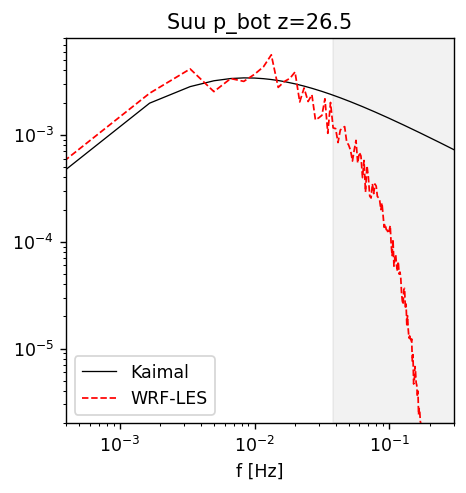

In [8]:
fig, axs = plt.subplots(1,len(grouplist), figsize=(4*len(grouplist),4), dpi=125)
nband=3
dx=10

for igroup, group in enumerate(grouplist):
    name = group['name']
    z    = group['z']
    U    = avgUlong[name]
    f, Suu = windspectra.NarrowToOctaveBand(favg[name], Suu_avg[name], nband)
    ax = axs
    ax.loglog(favg[name], utau**2*Suu_Kai[name]/avgUlong[name]**2, '-', color='k', lw=0.75, label='Kaimal')
    ax.loglog(favg[name], favg[name]*Suu_avg[name]/U**2, '--', linewidth=1, color='r', label='WRF-LES')
    
    ax.set_ylim([2E-6, 8E-3]);
    ax.set_xlim([4E-4, 0.3]);
    ax.set_title('Suu %s z=%0.1f'%(name, z))
    ax.set_xlabel('f [Hz]')
    
    fmax=0.6*U/(8.0*dx)
    ax.axvspan(fmax, 10, alpha=0.1, color='gray')
    ax.legend()

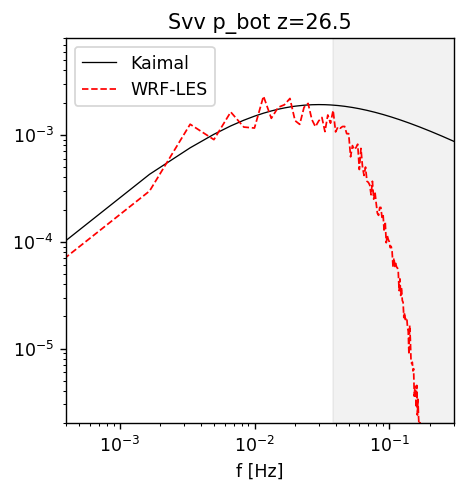

In [9]:
fig, axs = plt.subplots(1,len(grouplist), figsize=(4*len(grouplist),4), dpi=125)
nband=3
dx=10

for igroup, group in enumerate(grouplist):
    name = group['name']
    z    = group['z']
    U    = avgUlong[name]
    f, Svv = windspectra.NarrowToOctaveBand(favg[name], Svv_avg[name], nband)
    ax = axs
    ax.loglog(favg[name], utau**2*Svv_Kai[name]/avgUlong[name]**2, '-', color='k', lw=0.75, label='Kaimal')
    ax.loglog(favg[name], favg[name]*Svv_avg[name]/U**2, '--', linewidth=1, color='r', label='WRF-LES')
    
    ax.set_ylim([2E-6, 8E-3]);
    ax.set_xlim([4E-4, 0.3]);
    ax.set_title('Svv %s z=%0.1f'%(name, z))
    ax.set_xlabel('f [Hz]')
    
    fmax=0.6*U/(8.0*dx)
    ax.axvspan(fmax, 10, alpha=0.1, color='gray')
    ax.legend()

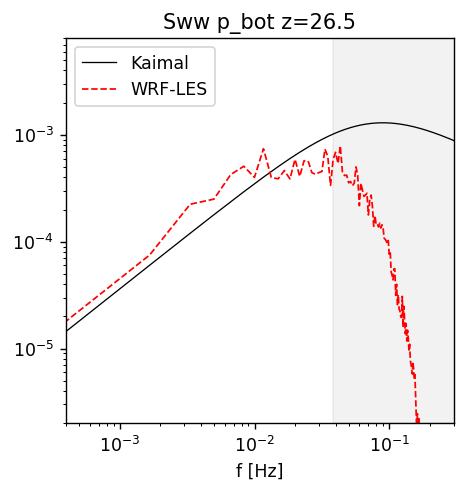

In [10]:
fig, axs = plt.subplots(1,len(grouplist), figsize=(4*len(grouplist),4), dpi=125)
nband=3
dx=10

for igroup, group in enumerate(grouplist):
    name = group['name']
    z    = group['z']
    U    = avgUlong[name]
    f, Sww = windspectra.NarrowToOctaveBand(favg[name], Sww_avg[name], nband)
    ax = axs
    ax.loglog(favg[name], utau**2*Sww_Kai[name]/avgUlong[name]**2, '-', color='k', lw=0.75, label='Kaimal')
    ax.loglog(favg[name], favg[name]*Sww_avg[name]/U**2, '--', linewidth=1, color='r', label='WRF-LES')
    
    ax.set_ylim([2E-6, 8E-3]);
    ax.set_xlim([4E-4, 0.3]);
    ax.set_title('Sww %s z=%0.1f'%(name, z))
    ax.set_xlabel('f [Hz]')
    
    fmax=0.6*U/(8.0*dx)
    ax.axvspan(fmax, 10, alpha=0.1, color='gray')
    ax.legend()